# Business Intelligence for Online Bidding Systems using Machine Learning

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
bids_df = pd.read_csv('/content/drive/MyDrive/CMPE 295/zip_data/bids.csv.zip')
train_df = pd.read_csv('/content/drive/MyDrive/CMPE 295/zip_data/train.csv.zip')
test_df = pd.read_csv('/content/drive/MyDrive/CMPE 295/zip_data/test.csv.zip')

### Cleaning the data

In [4]:
bids_df.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [5]:
train_df.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [6]:
bids_df.shape

(7656334, 9)

In [7]:
train_df.shape

(2013, 4)

#### Checking the missing values

In [8]:
# bids_df.isnull().sum()

In bids data, the column country has some missing values.

In [9]:
# percent_missing = bids_df['country'].isnull().mean()
# print(f"Percentage of missing country data: {percent_missing*100: .2f}%")

Hence, only a small portion of data is missing in the entire dataset.

#### Distribution of the countries

In [10]:
# unique_countries = bids_df['country'].value_counts()

In [11]:
# fig, ax = plt.subplots(figsize = (15, 4))
# countries_distribution = sns.barplot(x = unique_countries.index, y = unique_countries.values, ax = ax)                        
# ax.get_xaxis().set_visible(False)

# plt.show()

We can see the distribution of the countries and find that there is one country that is significantly higher than the rest. Hence, mode imputation may be a good approach.

In [12]:
# bids_df['country'] = bids_df['country'].fillna(bids_df['country'].mode()[0])

In [13]:
# bids_df.isnull().sum()

In [14]:
# train_df.isnull().sum()

Train data does not have any missing data.

#### Analyze Dataset: The datasets are provided by two part:

1. train.csv: the base bidder dataset with labels. Besides label, it also contains unique bidder_id followed with payment_account, address and outcome;
2. bids.csv: the dataset contains some more useful information associated with unique key bid_id, corresponding with bidder_id, auction, merchandise, device, time, country, ip, and url. time and url are encrypted information.

Since both of these two files contains the unique key bidder_id, we firstly joined these data by this key. Our object is to try to find each bid is made by a human or robot, thus, we only consider the data which have bids information and labelled. We will left join on train.csv and check the joined data for missing bids information.

In [15]:
# Populate train and test data with bid details
def populate_bids(df):
    df = pd.merge(left=df, right=bids_df, how='left', left_on='bidder_id', right_on='bidder_id')
    return df

In [16]:
test = populate_bids(test_df)
test.isna().sum()

bidder_id             0
payment_account       0
address               0
bid_id               70
auction              70
merchandise          70
device               70
time                 70
country            6228
ip                   70
url                  70
dtype: int64

In [17]:
train = populate_bids(train_df)
train.isna().sum()

bidder_id             0
payment_account       0
address               0
outcome               0
bid_id               29
auction              29
merchandise          29
device               29
time                 29
country            2730
ip                   29
url                  29
dtype: int64

Data Cleaning: Since we can see all the missing values are from the variables that come from bids, we want to check if there exist some of bidder_id do not have any bids.

In [18]:
nobids_train = train[pd.isnull(train['bid_id'])]['bidder_id'].unique()
len(nobids_train)

29

In [19]:
nobids_test = test[pd.isnull(test['bid_id'])]['bidder_id'].unique()
len(nobids_test)

70

In [20]:
# Check outcome for these in the train
train[train['bidder_id'].isin(nobids_train)]['outcome']

17583      0.0
42424      0.0
129439     0.0
214915     0.0
221776     0.0
226432     0.0
255107     0.0
305088     0.0
333331     0.0
409451     0.0
654549     0.0
657208     0.0
788183     0.0
790914     0.0
794927     0.0
810369     0.0
883351     0.0
1018748    0.0
1019599    0.0
1021349    0.0
1123023    0.0
1139921    0.0
1217466    0.0
1465813    0.0
1482542    0.0
1648201    0.0
1974826    0.0
2139077    0.0
2999380    0.0
Name: outcome, dtype: float64

##### There exist 29 bidder in training data set having no bid data. After checking with their labels, they were all marked as human. Since we aim to detect robot, we will just ignore them. We will update populate_bids function.

In [21]:
# Populate train and test data with bid details
def populate_bids_with_data_cleanup(df):
    df = pd.merge(left=df, right=bids_df, how='left', left_on='bidder_id', right_on='bidder_id')
    nobids = df[pd.isnull(df['bid_id'])]['bidder_id'].unique()
    # for all the missing value observation, drop it
    df = df[~df['bidder_id'].isin(nobids)]
    return df

In [22]:
test_data = populate_bids_with_data_cleanup(test_df)
test_data.isna().sum()

bidder_id             0
payment_account       0
address               0
bid_id                0
auction               0
merchandise           0
device                0
time                  0
country            6158
ip                    0
url                   0
dtype: int64

In [23]:
train_data = populate_bids_with_data_cleanup(train_df)
train_data.isna().sum()

bidder_id             0
payment_account       0
address               0
outcome               0
bid_id                0
auction               0
merchandise           0
device                0
time                  0
country            2701
ip                    0
url                   0
dtype: int64

In [24]:
# check the missing value ratio of the country entry in train data
count_miss_ratio_train = pd.isnull(train_data['country']).sum()/len(train_data)*100
print(f" %0.2f %% observations missing country entry in train data." %
      float(count_miss_ratio_train))

 0.09 % observations missing country entry in train data.


In [25]:
# check the missing value ratio of the country entry in test data
count_miss_ratio_test = pd.isnull(test_data['country']).sum()/len(test_data)*100
print(f" %0.2f %% observations missing country entry in test data." %
      float(count_miss_ratio_test))

 0.13 % observations missing country entry in test data.


For the full data set, there is only few of observations missing country entry. We will just ignore the missing country entry data.

In [26]:
# Populate train and test data with bid details
def populate_bids_with_data_cleanup_final(df):
    df = pd.merge(left=df, right=bids_df, how='left', left_on='bidder_id', right_on='bidder_id')
    nobids = df[pd.isnull(df['bid_id'])]['bidder_id'].unique()
    # for all the missing value observation, drop it
    df = df[~df['bidder_id'].isin(nobids)]
    # remove missing country data
    df = df.dropna()
    return df

In [27]:
train = populate_bids_with_data_cleanup_final(train_df)
train.isna().sum()

bidder_id          0
payment_account    0
address            0
outcome            0
bid_id             0
auction            0
merchandise        0
device             0
time               0
country            0
ip                 0
url                0
dtype: int64

In [28]:
test = populate_bids_with_data_cleanup_final(test_df)
test.isna().sum()

bidder_id          0
payment_account    0
address            0
bid_id             0
auction            0
merchandise        0
device             0
time               0
country            0
ip                 0
url                0
dtype: int64

### Exploring data

#### Checking the unique no of each feature in train and bids data

In [29]:
print(f"Total no of row in train:          {len(train)}")
print(f"Total no of bids in train:         {len(train['bid_id'].unique())}")
print(f"Total no of bidder in train:      {len(train['bidder_id'].unique())}")
print(f"Total no of payment in train:     {len(train['payment_account'].unique())}")
print(f"Total no of address in train:     {len(train['address'].unique())}")
print(f"Total no of auction in train:     {len(train['auction'].unique())}")
print(f"Total no of merchandise in train: {len(train['merchandise'].unique())}")
print(f"Total no of device in train:      {len(train['device'].unique())}")
print(f"Total no of country in train:     {len(train['country'].unique())}")
print(f"Total no of ip in train:          {len(train['ip'].unique())}")
print(f"Total no of url in train:         {len(train['url'].unique())}")

Total no of row in train:          3068523
Total no of bids in train:         3068523
Total no of bidder in train:      1983
Total no of payment in train:     1983
Total no of address in train:     1983
Total no of auction in train:     12740
Total no of merchandise in train: 10
Total no of device in train:      5726
Total no of country in train:     198
Total no of ip in train:          1028810
Total no of url in train:         663265


In [30]:
print(f"total bids made by robots in data set: {len(train[train['outcome'] == 1])}")
print(f"total bids made by human in data set:  {len(train[train['outcome'] == 0])}")
print("the ratio of made by robot vs. bids made by human in data set: 3:20")

total bids made by robots in data set: 412153
total bids made by human in data set:  2656370
the ratio of made by robot vs. bids made by human in data set: 3:20


### Feature Engineering

In [31]:
# bidding time difference per user (bidder_id)
def calculate_bidding_time_difference_per_user(df):
    df = df.sort_values(by=['time'])
    df['timediffs'] = df.groupby('bidder_id')['time'].transform(pd.Series.diff)
    return df

In [32]:
# number of bids a user made per auction
def bids_user_made_per_auction(df):
    bids_per_auction = df.groupby(['auction', 'bidder_id']).size()
    return bids_per_auction.to_frame()

In [33]:
# proportion of bots for each country
def proportion_of_bots_for_each_country(df):
    pbots_country = df[df['outcome'] == 1].groupby('country').size()/df.groupby('country').size()
    pbots_country = pbots_country.fillna(0)
    return pbots_country.to_frame()

In [34]:
# proportion of bots per device
def proportion_of_bots_per_device(df):
    pbots_device = df[df['outcome'] == 1].groupby('device').size()/df.groupby('device').size()
    pbots_device = pbots_device.fillna(0)
    return pbots_device.to_frame()

In [35]:
# number of unique ip to number of bids ratio
def number_of_unique_ip_to_number_of_bids_ratio(df):
    ip_bids_ratio = df.groupby('bidder_id')['ip'].nunique()/df.groupby('bidder_id')['bid_id'].nunique()
    return ip_bids_ratio.to_frame()

In [36]:
from scipy import stats

def ent(data):
    p_data = data.value_counts()/len(data)  # calculates the probabilities
    # input probabilities to get the entropy
    entropy = stats.entropy(p_data)
    return entropy

In [37]:
# mean per auction url entropy for each user
# Input a pandas series
def mean_per_auctio_url_entropy_for_each_user(df):
    auction_url_entropy = df.groupby(['auction', 'bidder_id'])['url'].apply(ent)
    return auction_url_entropy.groupby('bidder_id').mean().reset_index()

In [38]:
def feature_engineering(df):
    df = df.sort_values(by=['time'])
    df['timediffs'] = df.groupby('bidder_id')['time'].transform(pd.Series.diff)
    df = pd.merge(df, bids_user_made_per_auction(df), on=['auction', 'bidder_id'], how='left')
    df = pd.merge(df, proportion_of_bots_for_each_country(df), on='country', how='left')
    df = pd.merge(df, proportion_of_bots_per_device(df), on='device', how='left')
    df = pd.merge(df, number_of_unique_ip_to_number_of_bids_ratio(df), on='bidder_id', how='left')
    df = pd.merge(df, mean_per_auctio_url_entropy_for_each_user(df), on='bidder_id', how='left')
    return df

In [39]:
train = feature_engineering(train)
train.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  import sys


bidder_id             0
payment_account       0
address               0
outcome               0
bid_id                0
auction               0
merchandise           0
device                0
time                  0
country               0
ip                    0
url_x                 0
timediffs          1983
0_x                   0
0_y                   0
0_x                   0
0_y                   0
url_y                 0
dtype: int64

In [40]:
train.columns

Index(['bidder_id', 'payment_account', 'address', 'outcome', 'bid_id',
       'auction', 'merchandise', 'device', 'time', 'country', 'ip', 'url_x',
       'timediffs', '0_x', '0_y', '0_x', '0_y', 'url_y'],
      dtype='object')

In [41]:
# set column names
train.columns = ['bidder_id', 'payment_account', 'address', 'outcome',
               'bid_id', 'auction', 'merchandise', 'device', 'time', 'country',
               'ip', 'url', 'timediffs', 'bids_per_auction', 'pbots_country', 'pbots_device',
               'ip_bids_ratio', 'auction_url_entropy']
train.head()

,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url,timediffs,bids_per_auction,pbots_country,pbots_device,ip_bids_ratio,auction_url_entropy
0,76218e14c379c12d599dae9e1c00b61a3i5b2,a3d2de7675556553a5f08e4c88d2c228sjo4q,ca8d4b018cb62966eebb2974f5a83b4fstk6z,0.0,2351187.0,6hpvy,sporting goods,phone1161,9.631917e+15,cz,121.169.96.51,f33fl83l4vrg6is,NaN,368,0.089199,0.020161,0.178624,1.463760
1,6e178db6d17d21aa88aaca5bf15c2761lc500,a3d2de7675556553a5f08e4c88d2c228mqaf6,0d11440b07e5e2c8550af74b728ab4edk47gk,0.0,2351200.0,jqx39,jewelry,phone99,9.631917e+15,sa,174.12.78.255,omwhmwzvrn6ycq6,NaN,15452,0.177281,0.055360,0.583490,0.885604
2,197e90906939267ace2422e78e8e83889znqp,faef6512727719c3dd147a06ba951c947c4fn,dd7151709002fc3dce968916d8ec00ede03vc,0.0,2351192.0,gst86,home goods,phone348,9.631917e+15,ma,154.151.182.60,vasstdc27m7nks3,NaN,2386,0.095494,0.065255,0.461730,0.809338
3,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,0.0,2351190.0,fagyq,sporting goods,phone1,9.631917e+15,in,161.192.187.34,3skc4v2r07bneta,NaN,851,0.133801,0.056095,0.196636,1.747853
4,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,0.0,2351188.0,64uay,sporting goods,phone0,9.631917e+15,ke,17.120.130.121,vasstdc27m7nks3,0.0,12,0.035496,0.009222,0.196636,1.747853


In [42]:
train.timediffs = train.timediffs.fillna(0)
train.head()

,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url,timediffs,bids_per_auction,pbots_country,pbots_device,ip_bids_ratio,auction_url_entropy
0,76218e14c379c12d599dae9e1c00b61a3i5b2,a3d2de7675556553a5f08e4c88d2c228sjo4q,ca8d4b018cb62966eebb2974f5a83b4fstk6z,0.0,2351187.0,6hpvy,sporting goods,phone1161,9.631917e+15,cz,121.169.96.51,f33fl83l4vrg6is,0.0,368,0.089199,0.020161,0.178624,1.463760
1,6e178db6d17d21aa88aaca5bf15c2761lc500,a3d2de7675556553a5f08e4c88d2c228mqaf6,0d11440b07e5e2c8550af74b728ab4edk47gk,0.0,2351200.0,jqx39,jewelry,phone99,9.631917e+15,sa,174.12.78.255,omwhmwzvrn6ycq6,0.0,15452,0.177281,0.055360,0.583490,0.885604
2,197e90906939267ace2422e78e8e83889znqp,faef6512727719c3dd147a06ba951c947c4fn,dd7151709002fc3dce968916d8ec00ede03vc,0.0,2351192.0,gst86,home goods,phone348,9.631917e+15,ma,154.151.182.60,vasstdc27m7nks3,0.0,2386,0.095494,0.065255,0.461730,0.809338
3,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,0.0,2351190.0,fagyq,sporting goods,phone1,9.631917e+15,in,161.192.187.34,3skc4v2r07bneta,0.0,851,0.133801,0.056095,0.196636,1.747853
4,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,a3d2de7675556553a5f08e4c88d2c228sezhf,a3d2de7675556553a5f08e4c88d2c228nfhse,0.0,2351188.0,64uay,sporting goods,phone0,9.631917e+15,ke,17.120.130.121,vasstdc27m7nks3,0.0,12,0.035496,0.009222,0.196636,1.747853


### Data Visualization

In [43]:
pip install beautifultable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from beautifultable import BeautifulTable
import warnings

In [45]:
warnings.filterwarnings('ignore')

In [46]:
bots = train.loc[train.outcome == 1]
human = train.loc[train.outcome == 0]
bots.shape, human.shape

((412153, 18), (2656370, 18))

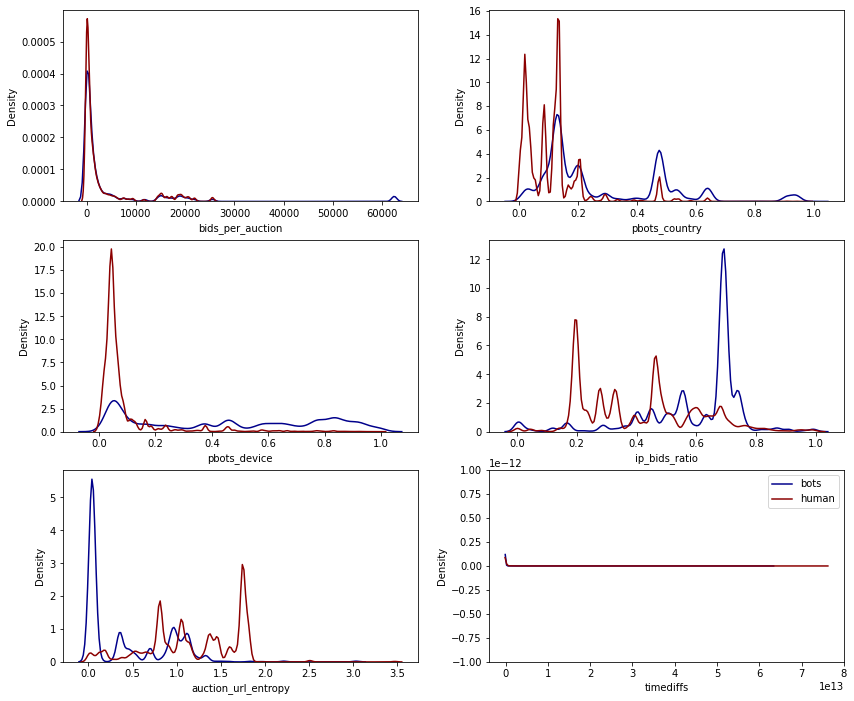

In [47]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=False)
sns.distplot(train['bids_per_auction'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])
sns.distplot(human['bids_per_auction'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])

sns.distplot(bots['pbots_country'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])
sns.distplot(human['pbots_country'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])

sns.distplot(bots['pbots_device'], hist=False, kde=True,
             bins=int(180/5), color='darkblue', label='bots',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])
sns.distplot(human['pbots_device'], hist=False, kde=True,
             bins=int(180/5), color='darkred', label='human',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])

sns.distplot(bots['ip_bids_ratio'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])
sns.distplot(human['ip_bids_ratio'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])

sns.distplot(bots['auction_url_entropy'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])
sns.distplot(human['auction_url_entropy'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])

sns.distplot(bots['timediffs'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
sns.distplot(human['timediffs'], hist=False, kde=True,
             bins=int(180/5), color='darkred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
plt.legend(['bots', 'human'])
plt.show()

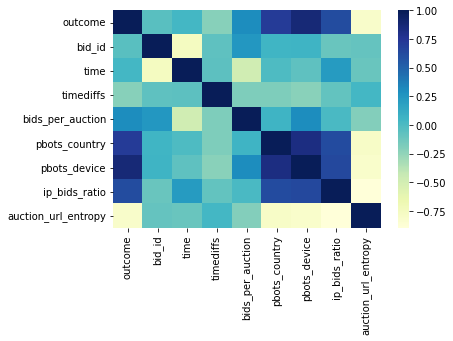

In [48]:
corr_matrix = train.corr()
sns.heatmap(corr_matrix.corr(),
            xticklabels=corr_matrix.corr().columns,
            yticklabels=corr_matrix.corr().columns,
            cmap="YlGnBu",
            fmt='d')

## Modeling

In [49]:
# for train and test data set split
from sklearn.model_selection import train_test_split
bid_train, bid_test = train_test_split(train, test_size=0.2)

### 1. Undersampling

From data preprocessing part, we see the ratio of the robot bidder and the human bidder is 3:20, thus we need to undersampling the human bidder samples in the trainset to keep the data balance.

In [50]:
# Balance train data
bots_train = bid_train.loc[bid_train.outcome == 1]
human_train = bid_train.loc[bid_train.outcome == 0]
human_sample = human_train.sample(n=len(bots_train))
bid_train_balance = pd.concat([bots_train, human_sample])
bid_train_balance.head()

,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url,timediffs,bids_per_auction,pbots_country,pbots_device,ip_bids_ratio,auction_url_entropy
2401579,46a28eaed47c29b4fd148a50cde44840u0bsn,b5445055af775b6cbd13e1872b97f8f1jhbrd,a713e4323ca6330ec8b6ae4a87ecf99b1497i,1.0,648832.0,h1ko2,mobile,phone17,9.763056e+15,tr,157.191.249.131,vasstdc27m7nks3,5.263158e+08,1565,0.078637,0.376879,0.737734,0.358151
1335551,8c33cf751b05ca6a9d886a379a84a2ees9jlu,cd1ea709310b008859c0cdac916b9689qnduo,b9a1f8858fa2679f9dc45ebae7fc660condo9,1.0,5583602.0,u077v,mobile,phone1029,9.697209e+15,au,26.76.194.175,vasstdc27m7nks3,9.473684e+08,657,0.526785,0.874638,0.556040,0.071472
738158,1aa485901ede7baf78ea116e297e9d7f9en6i,a3d2de7675556553a5f08e4c88d2c228n1tgz,ca8d4b018cb62966eebb2974f5a83b4fo1zpr,1.0,4117806.0,85448,sporting goods,phone189,9.640691e+15,in,238.214.32.189,j9hfsrcqsfi6392,1.789474e+09,32,0.133801,0.039965,0.688275,1.135521
2619785,a4e83190edb97fefdc4a6cbfd00f41fbm7c4o,a3d2de7675556553a5f08e4c88d2c228qteoy,3a7e6a32b24aeab0688e91a41f3188e2mhc65,1.0,1201729.0,vobqp,mobile,phone28,9.766176e+15,za,197.245.57.108,vasstdc27m7nks3,1.947368e+09,210,0.086032,0.237663,0.506430,0.449011
2987356,46a28eaed47c29b4fd148a50cde44840u0bsn,b5445055af775b6cbd13e1872b97f8f1jhbrd,a713e4323ca6330ec8b6ae4a87ecf99b1497i,1.0,2128614.0,19feo,mobile,phone248,9.771573e+15,dk,198.219.184.175,vasstdc27m7nks3,2.368421e+09,91,0.240370,0.591015,0.737734,0.358151


In [51]:
train_columns = ['bids_per_auction','pbots_country','pbots_device','ip_bids_ratio','auction_url_entropy']
X_train = bid_train_balance[train_columns]
y_train = bid_train_balance['outcome']

X_test = bid_test[train_columns]
y_test = bid_test['outcome']
X_train.shape, y_train.shape

((658774, 5), (658774,))

### 2: Bagging Models

In [52]:
import xgboost as xgb
import lightgbm as lgb

In [53]:
from sklearn.ensemble import BaggingRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,roc_curve,auc,classification_report
import matplotlib.pyplot as plt

In [54]:
random_state = 42

linear_regression = make_pipeline(LinearRegression())
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state= random_state))
elastic_net = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio= .9, random_state= random_state))

In [55]:
models_scores = []

In [56]:
def rmse(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return mean_squared_error(y_test, y_pred, squared= False)

In [57]:
def bagging_predictions(estimator):
    regr = BaggingRegressor(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= -1,
                            random_state=random_state).fit(X_train, y_train)

    br_y_pred = regr.predict(X_test)

    rmse_val = mean_squared_error(y_test, br_y_pred, squared= False) # squared= False > returns Root Mean Square Error   

    print(f'RMSE for base estimator {regr.base_estimator_} = {rmse_val}\n')
    return br_y_pred


predictions = np.column_stack((bagging_predictions(linear_regression),
                              bagging_predictions(lasso),
                              bagging_predictions(elastic_net)))
print(f"Bagged predictions shape: {predictions.shape}")
       
y_pred = np.mean(predictions, axis=1)
print("Aggregated predictions (y_pred) shape", y_pred.shape)

rmse_val = mean_squared_error(y_test, y_pred, squared= False) # squared= False > returns Root Mean Square Error   
models_scores.append(['Bagging', rmse_val])

print(f'\nBagging RMSE= {rmse_val}')

RMSE for base estimator Pipeline(steps=[('linearregression', LinearRegression())]) = 0.34382223898083053

RMSE for base estimator Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lasso', Lasso(alpha=0.0005, random_state=42))]) = 0.343817581320667

RMSE for base estimator Pipeline(steps=[('robustscaler', RobustScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42))]) = 0.34381800454729927

Bagged predictions shape: (613705, 3)
Aggregated predictions (y_pred) shape (613705,)

Bagging RMSE= 0.3438188642976172


In [97]:
print('Accuracy Score of Ensemble Bagging Regressor Model : ',accuracy_score(y_test,y_pred,normalize=True))

Accuracy Score of Ensemble Bagging Regressor Model :  0.999978817184152


In [58]:
gradient_boosting_regressor= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = random_state)
xgb_regressor= xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,verbosity=0, nthread = -1, random_state = random_state)
lgbm_regressor= lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,random_state = random_state)

In [59]:
gb_rmse= rmse(gradient_boosting_regressor)
xgb_rmse= rmse(xgb_regressor)
lgbm_rmse= rmse(lgbm_regressor)

In [60]:
print(f'GradientBoostingRegressor Score= {gb_rmse}')
print(f'XGBRegressor Score= {xgb_rmse}')
print(f'LGBMRegressor Score= {lgbm_rmse}')

GradientBoostingRegressor Score= 0.04720807920823864
XGBRegressor Score= 0.05463198175103816
LGBMRegressor Score= 0.23354251201324894


In [61]:
import pickle
model_file = "gradient_boosting_regressor.pickle"
with open(model_file,'wb') as f:
  pickle.dump(gradient_boosting_regressor, f)

In [62]:
import pickle
model_file = "xgb_regressor.pickle"
with open(model_file,'wb') as f:
  pickle.dump(xgb_regressor, f)

In [63]:
import pickle
model_file = "lgbm_regressor.pickle"
with open(model_file,'wb') as f:
  pickle.dump(lgbm_regressor, f)

#### AUC

In [64]:
y_gbr_pred = gradient_boosting_regressor.predict(X_test)
y_lgbm_pred = lgbm_regressor.predict(X_test)
y_xgb_pred = xgb_regressor.predict(X_test)

In [83]:
print(y_gbr_pred.shape)
print(y_lgbm_pred.shape)
print(y_xgb_pred.shape)
print(y_test.shape)

(613705,)
(613705,)
(613705,)
(613705,)


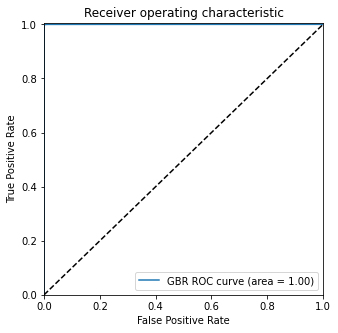

In [81]:
# Plot ROC in one graph
fpr_gbr, tpr_gbr, _gbr = roc_curve(y_test,y_gbr_pred )
roc_gbr_auc = auc(fpr_gbr, tpr_gbr)

plt.figure(figsize=(5, 5))
plt.plot(fpr_gbr, tpr_gbr, label='GBR ROC curve (area = %0.2f)' % roc_gbr_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
# fig.savefig('roc_bgr_auc.png')

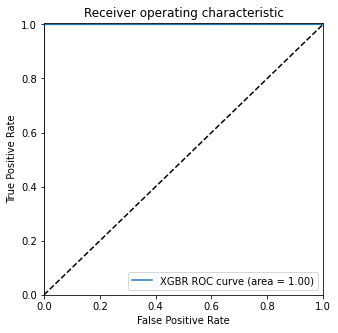

In [66]:
# Plot ROC in one graph
fpr_xgb, tpr_xgb, _xgb = roc_curve(y_test,y_xgb_pred)
roc_xgb_auc = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(5, 5))
plt.plot(fpr_xgb, tpr_xgb, label='XGBR ROC curve (area = %0.2f)' % roc_xgb_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
# fig.savefig('roc_xgbr_auc.png')

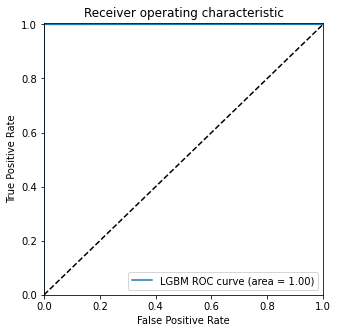

In [67]:
# Plot ROC in one graph
fpr_lgbm, tpr_lgbm, _gbr = roc_curve(y_test,y_xgb_pred)
roc_lgbm_auc = auc(fpr_lgbm, tpr_lgbm)

plt.figure(figsize=(5, 5))
plt.plot(fpr_lgbm, tpr_lgbm, label='LGBM ROC curve (area = %0.2f)' % roc_lgbm_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
# fig.savefig('roc_LGBM_auc.png')

#### Precision vs. Recall

In [91]:
print('Classification Report of XGB Regressor Model')
print(classification_report(y_test, y_xgb_pred.round()))

print('Classification Report of Gradient Boosting Regressor Model')
print(classification_report(y_test, y_gbr_pred.round()))

print('Classification Report of LGBM Regressor Model')
print(classification_report(y_test, y_lgbm_pred.round()))

Classification Report of XGB Regressor Model
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    530939
         1.0       1.00      1.00      1.00     82766

    accuracy                           1.00    613705
   macro avg       1.00      1.00      1.00    613705
weighted avg       1.00      1.00      1.00    613705

Classification Report of Gradient Boosting Regressor Model
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    530939
         1.0       0.99      1.00      0.99     82766

    accuracy                           1.00    613705
   macro avg       0.99      1.00      1.00    613705
weighted avg       1.00      1.00      1.00    613705

Classification Report of LGBM Regressor Model
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96    530939
         1.0       0.70      0.95      0.81     82766

    accuracy                    

In [93]:
print('Accuracy Score of XGB Regressor Model')
print(accuracy_score(y_test, y_xgb_pred.round(),normalize=True))

print('Accuracy Score of Gradient Boosting Regressor Model')
print(accuracy_score(y_test, y_gbr_pred.round(),normalize=True))

print('Accuracy Score of LGBM Regressor Model')
print(accuracy_score(y_test, y_lgbm_pred.round(),normalize=True))

Accuracy Score of XGB Regressor Model
0.999274895919049
Accuracy Score of Gradient Boosting Regressor Model
0.9983705526270765
Accuracy Score of LGBM Regressor Model
0.9391303639370707


### 2. XGB (eXtreme Gradient Boosting)

In [68]:
# import XGBoost
import xgboost as xgb

In [69]:
from xgboost import XGBClassifier


# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }         
           
          
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)


# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, learning_rate=1.0, max_depth=4)

In [70]:
print(xgb_clf)

XGBClassifier(alpha=10, learning_rate=1.0, max_depth=4)


In [71]:
y_pred = xgb_clf.predict(X_test)

In [72]:
from sklearn.metrics import accuracy_score,roc_curve

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 1.0000


In [73]:
from xgboost import cv
X_data = [X_train, X_test]
y_data = [y_train,y_test]
X = pd.concat(X_data)
y=pd.concat(y_data)
data_dmatrix = xgb.DMatrix(data=X,label=y)
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [74]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.962825,0.000063,0.962825,0.000126
1,0.965335,0.001408,0.965249,0.001166
2,0.969676,0.011529,0.969548,0.011699
3,0.975911,0.006128,0.975832,0.006193
4,0.971024,0.010654,0.970960,0.010706


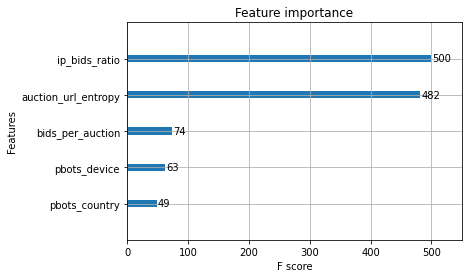

<Figure size 1152x864 with 0 Axes>

In [75]:
xgb.plot_importance(xgb_clf)
plt.figure(figsize = (16, 12))
plt.show()

In [76]:
import pickle
model_file = "xgb.pickle"
with open(model_file,'wb') as f:
  pickle.dump(xgb_clf, f)

#### AUC

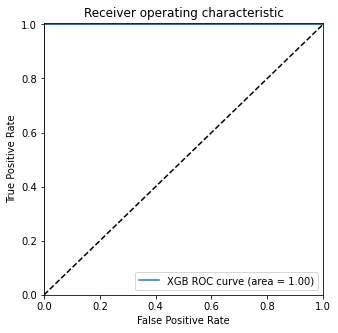

In [77]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pylab import rcParams

# Plot ROC in one graph
y_xgb_clf_score = xgb_clf.predict_proba(X_test)[:, 1]
fpr_xgb_clf, tpr_xgb_clf, _xgb_clf = roc_curve(y_test, y_xgb_clf_score)
roc_xgb_clf_auc = auc(fpr_xgb_clf, tpr_xgb_clf)

fig = plt.figure(figsize=(5, 5))
plt.plot(fpr_xgb_clf, tpr_xgb_clf, label='XGB ROC curve (area = %0.2f)' % roc_xgb_clf_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('roc_xgb_clf_auc.png')

In [78]:
print('Classification Report of XGB Model')
print(classification_report(y_test, y_pred))

Classification Report of XGB Model
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    530939
         1.0       1.00      1.00      1.00     82766

    accuracy                           1.00    613705
   macro avg       1.00      1.00      1.00    613705
weighted avg       1.00      1.00      1.00    613705

